<a href="https://colab.research.google.com/github/savpatpanda/protein/blob/master/notebook.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Setup

##Initialize from Git

In [1]:
%cd ~
!git clone https://github.com/savpatpanda/protein.git
%cd protein
!ls 
!pip3 install -r requirements.txt
# to push to GitHub, File > Save a copy in GitHub

/root
Cloning into 'protein'...
remote: Enumerating objects: 147, done.
remote: Counting objects: 100% (147/147), done.
remote: Compressing objects: 100% (132/132), done.
remote: Total 147 (delta 71), reused 46 (delta 15), pack-reused 0
Receiving objects: 100% (147/147), 2.86 MiB | 7.16 MiB/s, done.
Resolving deltas: 100% (71/71), done.
/root/protein
data  notebook.ipynb  plotting.py  proteinModel.py  requirements.txt
     |████████████████████████████████| 163kB 5.9MB/s 
     |████████████████████████████████| 1.8MB 12.4MB/s 
     |████████████████████████████████| 92kB 8.7MB/s 
     |████████████████████████████████| 296kB 27.9MB/s 
ERROR: datascience 0.10.6 has requirement folium==0.2.1, but you'll have folium 0.8.3 which is incompatible.
ERROR: albumentations 0.1.12 has requirement imgaug<0.2.7,>=0.2.5, but you'll have imgaug 0.2.9 which is incompatible.
  Found existing installation: certifi 2020.12.5
    Uninstalling certifi-2020.12.5:
      Successfully uninstalled certifi-2020.

##Parsing


In [12]:
import numpy as np
from plotting import plotSpheres
def getFractionalToCartesianRotationMatrix(a, b, c, alpha, beta, gamma):
  alpha = alpha*np.pi/180
  beta  = beta*np.pi/180
  gamma  = gamma*np.pi/180

  n2 = (np.cos(alpha) - np.cos(gamma) * np.cos(beta)) / np.sin(gamma)
  M  = np.array([ [a,0,0],
                  [b*np.cos(gamma),b*np.sin(gamma),0], 
                  [c*np.cos(beta), c*n2, c*np.sqrt(np.sin(beta)**2-n2**2)]
                 ])
  return M


In [13]:
import pandas as pd

def getResidues(pdbFile:str, allowHETATM:bool=False):
  pdb = open(pdbFile)
  data = [] ##residueCode, residueNumber, x, y, z, atomType - 2,5,6,7,8, 11
  positions = [2,3,5,6,7,8]

  for line in pdb:
      maxSubLength = len("ATOM    179  O   LYS A  22       7.513 -14.365  20.571")
      elements = line[:maxSubLength].split()
      if (elements[0] == "ATOM" or (allowHETATM and elements[0] == "HETATM")) \
          and elements[2] not in ["CA", "N", "O", "C"]:
          if len(elements) < 9:
            left = elements[2][:3]
            right = elements[2][3:]
            elements[2] = left
            elements.insert(3,right)
          item = []
          for i in positions:
            if i == 3:
              item.append(elements[i])
            elif i == 5:
              item.append(int(elements[i]))
            elif i in [6,7,8]:
              item.append(float(elements[i]))
            else:
              item.append(elements[i])
          item.append(line[-4])
          data.append(item)

  df = pd.DataFrame(data = data, 
                    columns = ["partOfResidue", "aminoAcid", "residueNumber", "x", "y", "z", "atomType"])
  df = df.groupby(by = ['residueNumber'])
  
  residues = []
  allProteinAtoms = []
  for key, item in df:
      atoms = []
      atomDf = df.get_group(key)
      for index, row in atomDf.iterrows():
        atoms.append(Atom(row["x"], row["y"], row["z"], row["atomType"], row["partOfResidue"], row["aminoAcid"], charge = 0))
      residues.append(Residue(atoms, atoms[0].aminoAcid ,atomDf["x"].mean(), atomDf["y"].mean(), atomDf["z"].mean()))
      allProteinAtoms.extend(atoms)
  return allProteinAtoms, residues

[[ 1.64328909  3.66464     0.73738568]
 [ 2.7647311   3.160752    0.08938008]
 [ 3.31124065  1.943568    0.45807292]
 [ 2.7665936   1.223728    1.5082889 ]
 [ 1.66647673  1.714528    2.16746701]
 [ 1.10873718  2.918624    1.79877417]
 [ 0.9687101   4.947264    0.41338288]
 [ 4.19177146  4.822928   -0.69269564]
 [ 4.67823603  5.490416   -1.9440168 ]
 [ 1.44030284  5.621296   -0.58097054]
 [-0.00787677  5.320272    1.07256099]
 [ 3.33524274  3.808608   -0.99435342]
 [ 4.47360496  5.114136    0.40221037]
 [ 4.16363519  1.5555088  -0.10613885]
 [ 3.20618445  0.2591424   1.7797809 ]
 [ 1.27388704  1.11248     3.00317078]
 [ 0.2498672   3.272       2.32723391]
 [ 5.34489471  6.28224    -1.56415145]
 [ 3.84326969  5.82416    -2.45795228]
 [ 5.10126693  4.77712    -2.68140249]
 [ 0.87355715  6.449112   -0.71727517]]


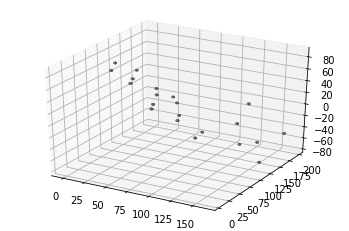

In [14]:
from gemmi import cif 
%matplotlib inline
import matplotlib.pyplot as plt

parseCIFNum = lambda num: float(num[:-4] if num[-1] == ')' else num)

def parseCIFFile(cifFileName):
  doc = cif.read_file(cifFileName)
  block = doc.sole_block()    
  fractionalSpace = [ block.find_pair("_cell_length_a"),
                      block.find_pair("_cell_length_b"),
                      block.find_pair("_cell_length_c"),
                      block.find_pair("_cell_angle_alpha"),
                      block.find_pair("_cell_angle_beta"),
                      block.find_pair("_cell_angle_gamma") ]

  fractionalSpace = map(lambda x: parseCIFNum(x[1]), fractionalSpace)
  rotationMatrix = getFractionalToCartesianRotationMatrix(*fractionalSpace)
  
  x = [parseCIFNum(x) for x in list(block.find_loop("_atom_site_fract_x"))]
  y = [parseCIFNum(x) for x in list(block.find_loop("_atom_site_fract_y"))]
  z = [parseCIFNum(x) for x in list(block.find_loop("_atom_site_fract_z"))]
  coords = np.array(list(zip(x,y,z)))

  return coords, rotationMatrix
  
try:
  coords, rotationMatrix = parseCIFFile("./data/185472.cif")
  cartesian = np.matmul(coords, rotationMatrix)
  fig = plt.figure()
  ax = fig.add_subplot(111, projection='3d')
  print(cartesian)
  plotSpheres(cartesian*30, ax)
  plt.show()
  
except Exception as e:
  print(e)


## Data Structures

In [55]:
from proteinModel import rotate, rotationMatrix

class Residue():
  def __init__ (self, atoms, name, meanX, meanY, meanZ):
    self.atoms = atoms
    self.name = name
    self.position = (meanX, meanY, meanZ)

class Atom():
  def __init__(self, x, y, z, atomType, residueComponents = None, aminoAcid = None, charge = 0):
    self.position = (x,y,z)
    self.atomType = atomType
    self.residueComponents = residueComponents
    self.aminoAcid = aminoAcid
    self.charge = charge
    
  def __repr__(self):
    return f"{self.atomType} at {self.position} in {self.aminoAcid}"

  @classmethod
  def fromAtom(cls, positions, atom):
    return cls(*positions, atom.atomType, atom.residueComponents, atom.aminoAcid, atom.charge)

  def translate(self, dx, dy, dz):
    return Atom(
        self.position[0] + dx,
        self.position[1] + dy,
        self.position[2] + dz,
        self.atomType,
        self.residueComponents,
        self.aminoAcid,
        self.charge
    )
    
class Compound():
  def __init__(self, atoms):
    self.atoms = atoms
    self.positions = [a.position for a in self.atoms]
    separated = list(zip(*self.positions))
    self.mean = list(map(lambda s: np.array(s).mean(), separated))

  def translate(self, dx, dy, dz):
    return list(map(lambda a: a.translate(dx,dy,dz), self.atoms))
  
  def rotate(self, a, b, g):
    dx, dy, dz = -1 * np.array(self.mean)
    atoms = rotateAtoms(translateAtoms(self.atoms, (dx, dy, dz)), a, b, g)
    atoms = translateAtoms(atoms, (-1*dx, -1*dy, -1*dz))
    return atoms

translatePositions = lambda positions, translate: [np.array(p) + np.array([*translate]) for p in positions]
translateAtoms = lambda atoms, translate: [a.translate(*translate) for a in atoms]

##Plotting

In [43]:
from proteinModel import rotate, rotationMatrix

def rotateAtoms(atoms, a, b, g):
  newAtoms = []
  newPos = rotate([atom.position for atom in atoms], rotationMatrix(a,b,g))
  for i, atom in enumerate(atoms):
    newAtoms.append(Atom.fromAtom(newPos[i], atom))
  return newAtoms

In [17]:
from matplotlib import cm, animation
from proteinModel import rotate, rotationMatrix
from IPython.display import display, HTML

def plot3d(atomList, fig = None, ax = None, radius = 2, color: str = "grey", intensities = []):
  if ax is None and fig is None:
    fig = plt.figure()
    fig.set_size_inches(10, 10)
    ax = fig.add_subplot(111, projection='3d')
    ax.set_xlabel('X')
    ax.set_ylabel('Y')
    ax.set_zlabel('Z')
  assert ax is not None and fig is not None
  if len(atomList) == 0 or isinstance(atomList[0], Atom):
    plotspheres(ax, [atom.position for atom in atomList], 
                radius = radius,
                color = color,
                intensities = intensities)
  else:
    plotspheres(ax, atomList, 
                radius = radius,
                color = color,
                intensities = intensities)
  return fig, ax

def animateThroughAxis(ax, frames):  
  def animate(frame):
    ax.view_init(30, frame*360/frames)
    plt.pause(.001)
    return fig
  return animate

def rotateFigure(fig, ax, frames):
  anim = animation.FuncAnimation(fig, animateThroughAxis(ax, frames), frames=frames, interval=100)
  display(HTML(anim.to_html5_video()))

def plotspheres(ax, atomList, radius = 2, color: str = "grey", intensities = []):
  cmap = cm.get_cmap('seismic')
  for index, i in enumerate(atomList):
    u, v = np.mgrid[0:2*np.pi:20j, 0:np.pi:20j]
    x = radius*np.cos(u)*np.sin(v) + i[0]
    y = radius*np.sin(u)*np.sin(v) + i[1]
    z = radius*np.cos(v) + i[2]
    try:
      value = None
      if intensities[index] > 0:
        value = cmap(0)
      else:
        value = cmap(abs(intensities[index]) / 0.3)
      color = value
      ax.text(*(np.array(i) + 1),f'{index + 1}', size=20, zorder=1, color='k') 
    except:
      pass
    finally:
      ax.plot_surface(x, y, z, color = color)
      


# Energy Calculation

## Loading Protein and Chemical Compound

In [52]:
proteinAtoms, _ = getResidues("./data/1ikf_P.pdb")
chemicalCompoundAtoms, _ = getResidues('./data/1ikf_C.pdb', allowHETATM = True)

## Constants

In [24]:
wellCoeff_kcal = {
    "C" : 0.15, 
    "N" : 0.16,
    "O" : 0.2,
    "S" : 0.2,
    "H" : 0.02,
    "P" : 0.36758504
} #kcal / mol

wellCoeff = {
    "C" : 0.0065047, 
    "N" : 0.0069383,
    "O" : 0.008673,
    "S" : 0.008673,
    "H" : 0.00086729,
    "P" : 0.01594012 ##check
} #volts (for one electron transfer)

atomicRadii = {
    "C" : 0.70, 
    "N" : 0.65,
    "O" : 0.60,
    "S" : 1.00,
    "H" : 0.25,
    "P" : 0.98
} #angstroms

partialCharges = {
    "N" : -0.15,
    "CA" : 0.12,
    "C" : 0.6,
    "O" : -0.57
} #note that N includes partial charge of covalently bonded hydrogen
#electrons

residueCharges = {
"GLY" : (0,None),
"ALA" : (0,None),
"SER" : (-0.01,'OG'),
"PRO" : (0,None),
"VAL" : (0,None),
"THR" : (-0.01,'OG1'),
"CYS" : (-0.04,'SG'),
"ILE" : (0,None),
"LEU" : (0,None),
"ASN" : (-0.02,'ND2'), #pretty sure
"ASP" : (-1,'OD2'), #again, not sure
"GLN" : (-0.01,'NE2'), #again, not sure
"LYS" : (0.99,'NZ'),
"GLU" : (-1,'OE2'), #not sure
"MET" : (-0.01,'SD'),
"HIS" : (0.8,'NE2'),
"PHE" : (-0.01,'CZ'), #not sure, benzene ring (center?)
"ARG" : (0.99,'NH2'), #not sure
"TYR" : (-0.01,'OH'),
"TRP" : (0,None)
} #at pH 7 - https://iubmb.onlinelibrary.wiley.com/doi/pdf/10.1016/0307-4412%2886%2990176-7

## Implementation / Functions

In [25]:
from proteinModel import rotate, rotationMatrix
from itertools import combinations

def boundingBox(atoms):
  minX, maxX = float('inf'), float('-inf')
  minY, maxY = float('inf'), float('-inf')
  minZ, maxZ = float('inf'), float('-inf')
  for atom in atoms:
    x,y,z = atom.position
    minX, maxX = min(minX, x), max(maxX, x)
    minY, maxY = min(minY, y), max(maxY, y)
    minZ, maxZ = min(minZ, z), max(maxZ, z)
  boundbox = []
  for x in [minX, maxX]:
    for y in [minY, maxY]:
      for z in [minZ, maxZ]:
        boundbox.append((x,y,z))
  volume = (maxX - minX) * (maxY - minY) * (maxZ - minZ)
  return boundbox, volume, ((minX, maxX), (minY, maxY), (minZ, maxZ))

def findMinBoundingBox(atoms, getPosition, rotateX, rotateY, rotateZ):
  deltas = range(0, 90, 5)
  smallestVolume, smallestBoundingBox, opt = float('inf'), None, None
  finalAtoms = None
  for dx,dy,dz in combinations(deltas, 3):
    vector = [getPosition(a) for a in atoms]
    atomSet = rotate(vector, rotationMatrix(dx, dy, dz))
    boundbox, volume = boundingBox(atomSet)
    if volume < smallestVolume:
      smallestVolume = volume
      smallestBoundingBox = boundbox
      opt = (dx, dy, dz)
      finalAtoms = atomSet
    
  return smallestVolume, smallestBoundingBox, opt, finalAtoms

def testBoundingBox():
  atoms, residues = getResidues('data/1ikf.pdb')
  _, bb, _, finalAtoms = findMinBoundingBox(atoms, lambda x : x.position, 30, 0, 0)
  fig = plt.figure()
  fig.set_size_inches(10, 10)
  ax = fig.add_subplot(111, projection='3d')
  plotAtoms(ax, finalAtoms, color = "green", radius = 0.2)
  plotAtoms(ax, bb, color = "red", radius = 0.3)
  plt.show()

In [26]:
import math

def LJ(type1, type2, distance):
  rij_min = (atomicRadii[type1] + atomicRadii[type2])/2
  ljEnergy = math.sqrt(wellCoeff[type1]*wellCoeff[type2]) * ((rij_min/distance)**12 - 2*(rij_min/distance)**6)
  return ljEnergy

def collect(atom):
  # / 6.2415e18 to get coulombs
  if atom.residueComponents in partialCharges.keys():
    return partialCharge[atom.residueComponents]
  elif atom.residueComponents == residueCharges[atom.aminoAcid][1]:
    return residueCharges[atom.aminoAcid][0]
  else:
    return 0

def electro(atom1, atom2, distance):
  cutoffCharge = 1 ##come back to this
  dielectric = 8.854187e-12 * 80.1 #C*V-1*m-1 #H20: https://chem.libretexts.org/Bookshelves/Analytical_Chemistry/Book%3A_Physical_Methods_in_Chemistry_and_Nano_Science_(Barron)/02%3A_Physical_and_Thermal_Analysis/2.09%3A_Electrical_Permittivity_Characterization_of_Aqueous_Solutions
  if abs(atom1.charge) < cutoffCharge or abs(atom2.charge) < cutoffCharge:
    return 0
  else:
    chargeCollect1, chargeCollect2 = collect(atom1), collect(atom2)
    electroEnergy = chargeCollect1 * chargeCollect2 / (dielectric * distance) ##needs to be in kcal/mol
    return electroEnergy

def potentialEnergy(proteinSet, compoundSet):
  totalEnergy = 0
  minimumDistance, cutOffDistance = 0.70 , 30
  tooCloseCounter = 0
  tooFarCounter = 0
  for i in proteinSet:
    for j in compoundSet:
      x,y,z = list(zip(i.position, j.position))
      distance = math.sqrt((x[0] - x[1])**2 + (y[0] - y[1])**2 + (z[0]-z[1])**2)
      if distance > cutOffDistance: #optional cutoff for particles too far away
        tooFarCounter += 1
        continue
      if distance <= minimumDistance:
        tooCloseCounter += 1
        continue
      totalEnergy += (LJ(i.atomType, j.atomType, distance) + electro(i, j, distance))
  # print(f'atoms too close: {tooCloseCounter}')
  # print(f'atoms too far: {tooFarCounter}')
  return totalEnergy  

## Sampling Protein Space

In [59]:
def distance(atom, x, y, z):
  x2, y2, z2 = atom.position
  return np.sqrt((x2-x)**2 + (y2-y)**2 + (z2-z)**2)

def sampleSpace(prot, chem):
  _, _, vertices = boundingBox(prot)
  _, _, chemicalVertices = boundingBox(chem)
  x, y, z = chemicalVertices
  dx = x[1] - x[0]
  dy = y[1] - y[0]
  dz = z[1] - z[0]
  maxdistance = (dx**2 + dy**2 + dz**2) ** 0.5
  considerSet = []
  finalPoints = []

  A = 0.8 #angstroms minimum distance from protein surface
  B = maxdistance / 2 #angstroms maximum distance from protein surface to conisder
  points = 5


  for x in np.linspace(vertices[0][0] - B, vertices[0][1] + B, points):
    for y in np.linspace(vertices[1][0] - B, vertices[1][1] + B, points):
      for z in np.linspace(vertices[2][0] - B, vertices[2][1] + B, points):
        counter = 0
        considerSet.append((x,y,z))
        for atom in proteinAtoms:
          dis = distance(atom, x, y, z)
          if dis < A: 
            continue
          if dis < B: 
            counter += 1
        if counter > 0:
          finalPoints.append(Atom(x, y, z, 'C'))

  return finalPoints
  #fig, axs = plot3d(proteinAtoms, radius = 1, color = 'blue')
  #_ = plot3d(finalPoints, fig = fig, ax = axs, radius = 1, color = 'red')
  #fig.show()

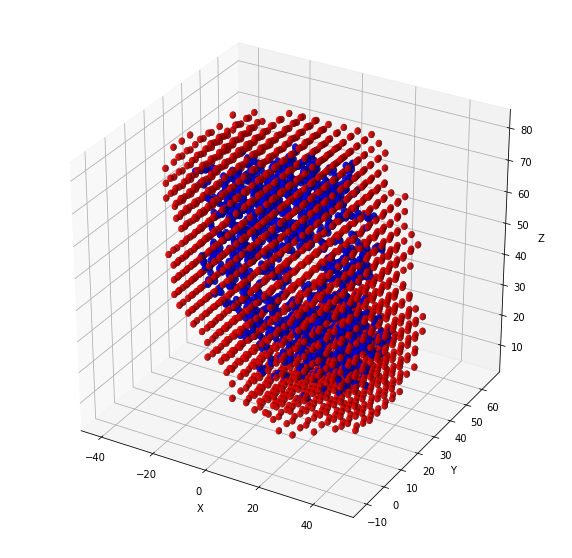



## Visualization

mean: [-16.91075, 38.05853125, 67.95309375]
Intensities


TypeError: ignored

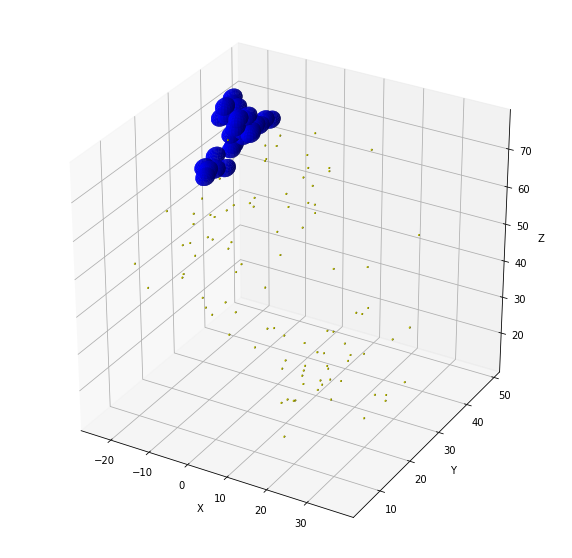

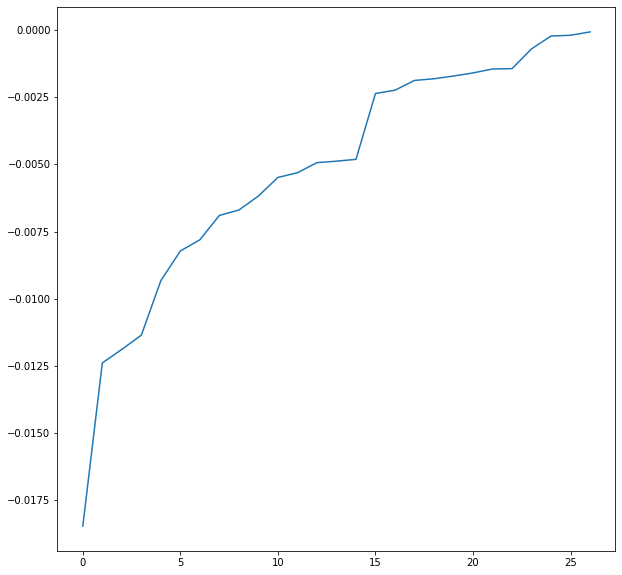

In [57]:
from random import sample 

def radialGridSearch(prot, chem, mean):
  points, intensities = [], []
  for i in range(-10, 100, 10):
    for j in range(-10, 100, 10):
      for k in range(-80, 10, 10):
        energy = potentialEnergy(prot, translateAtoms(chem, (i, j, k)))
        intensities.append(energy)
        points.append(np.array(mean) + np.array([i,j,k]))
  return points, intensities

#rotation at the present compound position
def rotationSearch(prot, compound):
  configurations, intensities = [], []
  rounds = 3
  for a in np.linspace(0, 360, rounds, endpoint = False):
    for b in np.linspace(0, 360, rounds, endpoint = False):
      for g in np.linspace(0, 360, rounds, endpoint = False):
        testAtoms = compound.rotate(a, b, g)
        energy = potentialEnergy(prot, testAtoms)
        intensities.append(energy)
        configurations.append((a, b, g))
  return configurations, intensities

def visualizeLeaders(leaders, fig = None, ax = None):
  for index, value in enumerate(leaders):
    point, intensity = value
    print(f"Place: {index + 1}\n\tPoint: {point}\n\tEnergy: {intensity}")
  points, intz = zip(*leaders)
  fig, ax = plot3d(points, fig=fig, ax=ax, radius = 1, color = "grey", intensities = intz)
  rotateFigure(fig, ax, 50)

def plotIntensities(intensities):
  print("Intensities")
  intensities.sort()
  fig = plt.figure()
  fig.set_size_inches(10, 10)
  ax = fig.add_subplot(111)
  ax.plot(intensities)

def heatmap(prot, chem):
  chemicalCompound = Compound(chem)
  print(f'mean: {chemicalCompound.mean}')
  fig, ax = plot3d(sample([p.position for p in prot], 100), color = "yellow", radius = 0.2)
  points, intensities = radialGridSearch(prot, chem, chemicalCompound.mean)
  visualizeLeaders(sorted(zip(points, intensities), key = lambda x: x[1])[:10], fig = fig, ax = ax)
  plotIntensities(intensities)  
  return points, intensities

def control(prot, chem):
  chemicalCompound = Compound(chem)
  #chemicalCompound = Compound(Compound(chem).translate(17, -38, -68))
  print(f'mean: {chemicalCompound.mean}')
  fig, ax = plot3d(sample([p.position for p in prot], 100), color = "yellow", radius = 0.2)
  configs, intensities = rotationSearch(prot, chemicalCompound)
  plotIntensities(sorted(intensities))
  return configs, intensities, fig, ax

one, two, fig, ax = control(proteinAtoms, chemicalCompoundAtoms)
three = sorted(zip(one, two), key = lambda x: x[1])[:10][0][0]
plot3d(Compound(chemicalCompoundAtoms).rotate(*three), fig = fig, ax = ax, color = 'blue')
plot3d(chemicalCompoundAtoms, fig = fig, ax = ax, color = 'red')
fig.show()

#points, intensities = heatmap(proteinAtoms, chemicalCompoundAtoms)  

##Notes
###Canon
```
atoms too close: 0
atoms too far: 30493
-0.001397307776869083
atoms too close: 1
atoms too far: 21708
c1 -0.2625228861619607
atoms too close: 0
atoms too far: 52197
c2 -1.6375793232228902e-09
atoms too close: 0
atoms too far: 20679
c3 -0.0663767545885685
```
###New
```
atoms too close: 0
atoms too far: 0
-0.0013975132154963592
atoms too close: 1
atoms too far: 0
c1 -0.26252317289579025
atoms too close: 0
atoms too far: 0
c2 -8.308525901431997e-08
atoms too close: 0
atoms too far: 0
c3 -0.06637716916093551
```

# Optimization Ideas
- Gradient Search
  - Bounding box optimization
  - Translate, rotate, translate
  - Informed search using important residues (e.g Euclidean distances)
  - How to descend:
    - PyTorch autograd. The idea is to convert our energy functions into matrix operations that take a central position of the compound, and use our resultant energy as loss. We can then use gradients from these computations to nudge our central position in the correct direction.
    - Beam search - from an initial position, compute different directions to translate and their resultant energies, and pick the locally optimal one, continue until you find the min.
- Residue / Active site pockets
    - Move the chemical compound along the normal of the plane in the pocket.


In [ ]:
import torch
#https://pytorch.org/tutorials/beginner/pytorch_with_examples.html
dtype = torch.float
device = torch.device("cpu")
epochs = 1000
learning_rate = 1e-3
# device = torch.device("cuda:0") # Uncomment this to run on GPU

# Create random Tensors for weights.
# Setting requires_grad=True indicates that we want to compute gradients with
# respect to these Tensors during the backward pass.
w1 = torch.randn(1, 3, device=device, dtype=dtype, requires_grad=True)
print(w1)

for t in range(epochs + 1):
    # Forward pass: compute predicted y using operations on Tensors; these
    # are exactly the same operations we used to compute the forward pass using
    # Tensors, but we do not need to keep references to intermediate values since
    # we are not implementing the backward pass by hand.
    '''
    Question: Is it possible to create these operations with matrix manipulation --
    w1 -> translated compound
    translated compound -> LJ 
    translated compound -> Electric Energies
    '''
    y_pred = w1 * torch.ones(3)

    # Compute and print loss using operations on Tensors.
    # Now loss is a Tensor of shape (1,)
    # loss.item() gets the scalar value held in the loss.
    loss = (y_pred - torch.tensor([5,5,5])).pow(2).sum()
    print(t, loss.item())

    # Use autograd to compute the backward pass. This call will compute the
    # gradient of loss with respect to all Tensors with requires_grad=True.
    # After this call w1.grad and w2.grad will be Tensors holding the gradient
    # of the loss with respect to w1 and w2 respectively.
    loss.backward()

    # Manually update weights using gradient descent. Wrap in torch.no_grad()
    # because weights have requires_grad=True, but we don't need to track this
    # in autograd.
    # An alternative way is to operate on weight.data and weight.grad.data.
    # Recall that tensor.data gives a tensor that shares the storage with
    # tensor, but doesn't track history.
    # You can also use torch.optim.SGD to achieve this.
    with torch.no_grad():
        w1 -= learning_rate * w1.grad

        # Manually zero the gradients after updating weights
        w1.grad.zero_()
print(w1)  


# New Section